<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

# Autoencoder
`An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.`

<img src="images/concept.png"/>

<img src="images/example_4.png" width="500" height="500"/>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Task 1: Project Overview and Import Libraries

In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.0.0


## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Task 3: Build the Encoder

In [3]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l1)

# By defauuuuuuuult max pooling is 2 by 2
l3 = MaxPooling2D(padding='same')(l2)

l4 = Conv2D(128, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l6)

In [4]:
encoder = Model(input_img,l7)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 128)       0     

## Task 4: Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

In [5]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l1)

# By defauuuuuuuult max pooling is 2 by 2
l3 = MaxPooling2D(padding='same')(l2)

l4 = Conv2D(128, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l6)

In [6]:
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14,l2])
decoded = Conv2D(3, (3,3), padding='same', activation='relu', 
            activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder = Model(input_img, decoded)

In [7]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [8]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

## Task 5: Create Dataset and Specify Training Routine

In [8]:
def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.9
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

def train_batches(just_load_dataset=False):

#     batches = 256 
    batches = 50 

    batch = 0 
    batch_nb = 0 
#     max_batches = -1 
    max_batches = 1
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    path = os.path.join('D:\\Python\\Datasets_Images\\Imagenet_cars_dataset','cars_train')
    
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    print('Loading Completed!')
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(resize(rescale(rescale(image, 0.84),1.16),(256, 256)))
#                     x_train_down.append(noisy(image_resized))
                    

                    
                    batch += 1
                    
                    print('Loading batch: '+str(batch_nb+1)+" Image: "+str(batch),end = "\r")
                    
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            print('Loading Completed!')
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0
                        
    print('Loading Completed!')
    return x_train_n2, x_train_down2

In [222]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

## Task 6: Load the Dataset and Pre-trained Model

In [16]:
autoencoder.load_weights(r"C:\Users\Fahad_Siddiqui\Python\Cousera Projects\Image Super Resolution Using Autoencoders in Keras\models\sr.img_net.mse.final_model5.patch.weights.best.hdf5")

In [12]:
encoder.load_weights(r'C:\Users\Fahad_Siddiqui\Python\Cousera Projects\Image Super Resolution Using Autoencoders in Keras\models\encoder_weights.hdf5')

## Task 7: Model Predictions and Visualizing the Results

In [13]:
encoded_imgs = encoder.predict(x_train_down)

In [229]:
encoded_imgs.shape

(50, 64, 64, 256)

In [230]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [231]:
image_index = 45

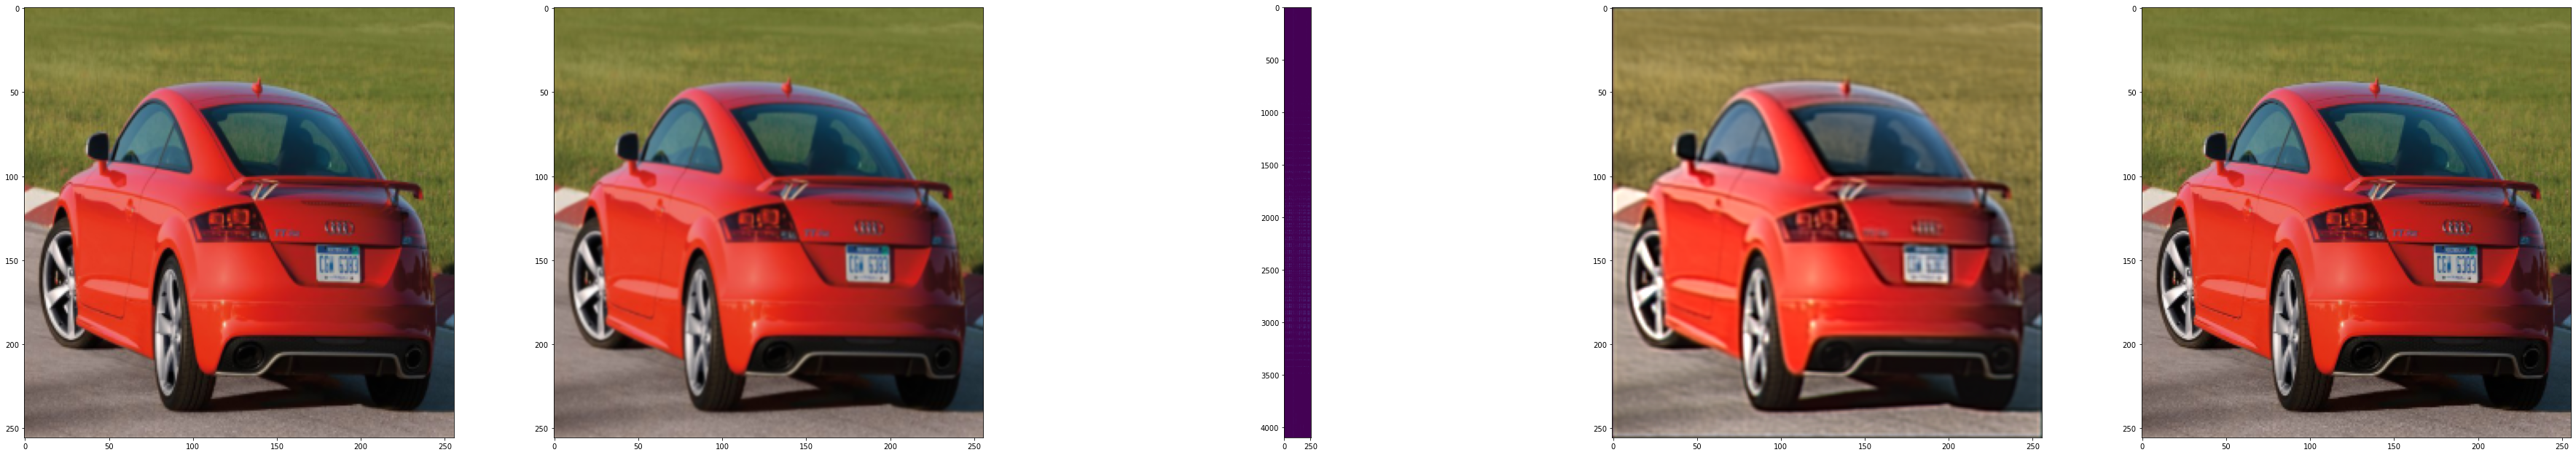

In [232]:
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

In [13]:
def display_prediction(low_res_img_path,expected_img_path=None):    
    image = pyplot.imread(low_res_img_path)
    image_resized_low_res_img = resize(image, (256, 256,3))
    predicted_high_res_img = np.clip(autoencoder.predict(np.array([image_resized_low_res_img])), 0.0, 1.0)    
    encoded_predicted_img = encoder.predict(np.array([image_resized_low_res_img]))

    plot_size = 30
    
    fig = plt.figure(figsize=(128,128))
    
    i = 1
    ax = plt.subplot(plot_size,plot_size, i)
    ax.set_title("Origional Low Quality Image")
    plt.imshow(image_resized_low_res_img)

    i += 1
    ax = plt.subplot(plot_size, plot_size, i)
    ax.set_title("Interpolated Image")
    plt.imshow(image_resized_low_res_img, interpolation="bicubic")

    i += 1
    ax = plt.subplot(plot_size,plot_size, i)
    ax.set_title("Predicted High Quality Image")
    plt.imshow(predicted_high_res_img[0])
   
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('prediction/predicted.jpg', bbox_inches=extent,dpi=250)
    
    if not expected_img_path == None:
        image = pyplot.imread(expected_img_path)
        image_resized = resize(image, (256, 256,3))
        i += 1
        ax = plt.subplot(plot_size,plot_size, i)
        ax.set_title("Origional High Quality Image")
        plt.imshow(image_resized)

    i += 1
    ax = plt.subplot(plot_size,plot_size, i)
    ax.set_title("Encoded Representation")
    plt.imshow(encoded_predicted_img[0].reshape((64*64, 256)))

    plt.savefig("prediction/predicted_img.jpg", bbox_inches='tight', pad_inches=0,dpi=250)
    plt.show()

### Prediction a Single image

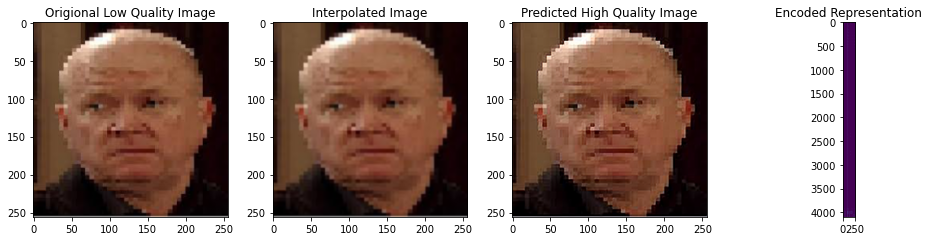

In [15]:
import os

from tensorflow.keras.preprocessing.image import img_to_array

base_path = r'C:\Users\Fahad_Siddiqui\Python\Cousera Projects\Image Super Resolution Using Autoencoders in Keras\images\test images'

img_path = os.path.join(base_path,'test_img4.jpg')
img_path_exp = os.path.join(base_path,'test_img_exp5.jpg')

# display_prediction(img_path,img_path_exp)
display_prediction(img_path)

In [62]:
def merge_images(images):
#     images = [Image.open(x) for x in lst]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new(mode = 'RGB', size  = (total_width+120, max_height+20) , color = (255,255,255) )

    lst = ["Origional Low","Predicted","Origional High"]
    
    x_offset = 0
    for im, name in zip(images,lst):
        new_im.paste(im, (x_offset,20))
        x_offset += im.size[0] + 40

    new_im.save('prediction\\predicted.jpg')

from PIL import ImageFont
from PIL import ImageDraw 

img = Image.open(img_path)
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
font = ImageFont.truetype("arial.ttf", 16)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((0, 0),"Sample Text",(255,255,255),font=font)
img.save('tmp.jpg')